# Exoplanet Model Evaluation on Test Data

This notebook evaluates the trained gradient boosting model on the test dataset (KOI-Playground-Test-Data.csv). It loads the saved model components and generates comprehensive performance metrics and visualizations for the final evaluation.

## 1. Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load the Saved Model and Preprocessing Components

In [2]:
# Load the trained model
print("Loading trained model...")
model = joblib.load('exoplanet_gradient_boosting_model.joblib')
print(f"Model loaded successfully: {type(model).__name__}")

# Load the label encoder
print("\nLoading label encoder...")
label_encoder = joblib.load('label_encoder.joblib')
print(f"Label encoder loaded successfully: {label_encoder.classes_}")

# Load feature names
print("\nLoading feature names...")
feature_names_df = pd.read_csv('feature_names.csv')
feature_names = feature_names_df['feature_names'].tolist()
print(f"Number of features: {len(feature_names)}")
print("Features:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i:2}. {feature}")

# Display model parameters
print(f"\n" + "="*60)
print("LOADED MODEL INFORMATION")
print("="*60)
print(f"Model Type: {type(model).__name__}")
print(f"Number of Features: {len(feature_names)}")
print(f"Model Parameters:")
key_params = ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'min_samples_split']
for param in key_params:
    if hasattr(model, param):
        print(f"  {param}: {getattr(model, param)}")
print("="*60)

Loading trained model...
Model loaded successfully: GradientBoostingClassifier

Loading label encoder...
Label encoder loaded successfully: ['candidate' 'non-candidate']

Loading feature names...
Number of features: 14
Features:
 1. koi_period
 2. koi_time0bk
 3. koi_impact
 4. koi_duration
 5. koi_depth
 6. koi_incl
 7. koi_model_snr
 8. koi_count
 9. koi_bin_oedp_sig
10. koi_steff
11. koi_slogg
12. koi_srad
13. koi_smass
14. koi_kepmag

LOADED MODEL INFORMATION
Model Type: GradientBoostingClassifier
Number of Features: 14
Model Parameters:
  n_estimators: 300
  learning_rate: 0.05
  max_depth: 7
  subsample: 0.9
  min_samples_split: 5
Model loaded successfully: GradientBoostingClassifier

Loading label encoder...
Label encoder loaded successfully: ['candidate' 'non-candidate']

Loading feature names...
Number of features: 14
Features:
 1. koi_period
 2. koi_time0bk
 3. koi_impact
 4. koi_duration
 5. koi_depth
 6. koi_incl
 7. koi_model_snr
 8. koi_count
 9. koi_bin_oedp_sig
10. koi_

## 3. Load and Prepare Test Data

In [3]:
# Load test dataset
print("Loading test dataset...")
test_df = pd.read_csv('data/KOI-Playground-Test-Data.csv')

print(f"Test dataset shape: {test_df.shape}")
print("\nTest dataset columns:")
print(test_df.columns.tolist())
print("\nFirst few rows:")
print(test_df.head())

# Check if test data has target variable (it might not)
has_target = 'koi_disposition' in test_df.columns
print(f"\nTarget variable present: {has_target}")

if has_target:
    print("\nTarget variable distribution in test data:")
    print(test_df['koi_disposition'].value_counts())
    print(test_df['koi_disposition'].value_counts(normalize=True))

Loading test dataset...
Test dataset shape: (1913, 16)

Test dataset columns:
['kepid', 'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']

First few rows:
     kepid koi_disposition  koi_period  koi_time0bk  koi_impact  koi_duration  \
0  7537660       candidate    2.421869   132.788660         NaN        6.2200   
1  3219037       candidate   10.005070   136.830290       0.148        3.4810   
2  9729691       candidate    8.689301   133.661284       0.029        2.5630   
3  7697568   non-candidate   22.841563   138.632000       1.267        2.5997   
4  9005854   non-candidate    1.890227   131.678589       0.957        3.8550   

   koi_depth  koi_incl  koi_model_snr  koi_count  koi_bin_oedp_sig  koi_steff  \
0        NaN       NaN            NaN          1               NaN        NaN   
1      143.3     89.61      

In [4]:
# Preprocess test data using the same steps as training data
print("Preprocessing test data...")
test_processed = test_df.copy()

# Store target if available for later evaluation
y_test_true = None
if has_target:
    # Encode target variable using the same label encoder
    y_test_true = label_encoder.transform(test_processed['koi_disposition'])
    print(f"Test target encoded successfully. Shape: {y_test_true.shape}")
    
    # Remove identifier and target columns
    columns_to_remove = ['kepid', 'koi_disposition']
else:
    # Remove only identifier column
    columns_to_remove = ['kepid'] if 'kepid' in test_processed.columns else []

for col in columns_to_remove:
    if col in test_processed.columns:
        test_processed = test_processed.drop(col, axis=1)
        print(f"Removed column: {col}")

# Handle missing values - fill with median for numerical columns
print("\nHandling missing values...")
numerical_columns = test_processed.select_dtypes(include=[np.number]).columns.tolist()

missing_info = []
for col in numerical_columns:
    missing_count = test_processed[col].isnull().sum()
    if missing_count > 0:
        median_value = test_processed[col].median()
        test_processed[col].fillna(median_value, inplace=True)
        missing_info.append(f"{col}: {missing_count} missing values filled with median {median_value:.3f}")
        
if missing_info:
    for info in missing_info:
        print(f"  {info}")
else:
    print("  No missing values found")

# Ensure feature alignment with training data
print(f"\nAligning features with training data...")
print(f"Test data columns: {test_processed.columns.tolist()}")
print(f"Expected features: {feature_names}")

# Reorder columns to match training data
X_test = test_processed[feature_names]
print(f"Final test feature matrix shape: {X_test.shape}")
print("Missing values after preprocessing:", X_test.isnull().sum().sum())

Preprocessing test data...
Test target encoded successfully. Shape: (1913,)
Removed column: kepid
Removed column: koi_disposition

Handling missing values...
  koi_impact: 76 missing values filled with median 0.546
  koi_depth: 76 missing values filled with median 396.000
  koi_incl: 76 missing values filled with median 88.410
  koi_model_snr: 76 missing values filled with median 22.600
  koi_bin_oedp_sig: 284 missing values filled with median 0.517
  koi_steff: 76 missing values filled with median 5769.000
  koi_slogg: 76 missing values filled with median 4.438
  koi_srad: 76 missing values filled with median 0.998
  koi_smass: 76 missing values filled with median 0.972

Aligning features with training data...
Test data columns: ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_incl', 'koi_model_snr', 'koi_count', 'koi_bin_oedp_sig', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag']
Expected features: ['koi_period', 'koi_time0bk', 'koi_impact

## 4. Make Predictions on Test Data

In [5]:
# Generate predictions on test data
print("Making predictions on test data...")
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

print(f"Predictions generated for {len(y_test_pred)} samples")
print(f"Prediction probabilities shape: {y_test_pred_proba.shape}")

# Display sample predictions
print(f"\nSample predictions (first 10 rows):")
print("Sample | Predicted Class | Candidate Prob | Non-candidate Prob | Confidence")
print("-" * 75)
for i in range(min(10, len(y_test_pred))):
    pred_class = label_encoder.inverse_transform([y_test_pred[i]])[0]
    candidate_prob = y_test_pred_proba[i, 0]
    non_candidate_prob = y_test_pred_proba[i, 1]
    confidence = np.max(y_test_pred_proba[i])
    print(f"{i+1:6} | {pred_class:15} | {candidate_prob:13.4f} | {non_candidate_prob:17.4f} | {confidence:10.4f}")

# Prediction statistics
print(f"\nPrediction Statistics:")
pred_classes = label_encoder.inverse_transform(y_test_pred)
unique, counts = np.unique(pred_classes, return_counts=True)
for class_name, count in zip(unique, counts):
    percentage = (count / len(pred_classes)) * 100
    print(f"{class_name}: {count} ({percentage:.1f}%)")

# Confidence statistics
confidence_scores = np.max(y_test_pred_proba, axis=1)
print(f"\nPrediction Confidence Statistics:")
print(f"Mean confidence: {np.mean(confidence_scores):.4f}")
print(f"Median confidence: {np.median(confidence_scores):.4f}")
print(f"Min confidence: {np.min(confidence_scores):.4f}")
print(f"Max confidence: {np.max(confidence_scores):.4f}")

Making predictions on test data...
Predictions generated for 1913 samples
Prediction probabilities shape: (1913, 2)

Sample predictions (first 10 rows):
Sample | Predicted Class | Candidate Prob | Non-candidate Prob | Confidence
---------------------------------------------------------------------------
     1 | non-candidate   |        0.4592 |            0.5408 |     0.5408
     2 | candidate       |        0.9318 |            0.0682 |     0.9318
     3 | candidate       |        0.9821 |            0.0179 |     0.9821
     4 | non-candidate   |        0.2509 |            0.7491 |     0.7491
     5 | non-candidate   |        0.0054 |            0.9946 |     0.9946
     6 | candidate       |        0.6939 |            0.3061 |     0.6939
     7 | candidate       |        0.7539 |            0.2461 |     0.7539
     8 | non-candidate   |        0.0598 |            0.9402 |     0.9402
     9 | non-candidate   |        0.0166 |            0.9834 |     0.9834
    10 | candidate       |   

## 5. Evaluate Model Performance on Test Set

In [6]:
# Evaluate model performance if we have true labels
if y_test_true is not None:
    print("Calculating performance metrics on test set...")
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true, y_test_pred)
    test_precision = precision_score(y_test_true, y_test_pred)
    test_recall = recall_score(y_test_true, y_test_pred)
    test_f1 = f1_score(y_test_true, y_test_pred)
    test_roc_auc = roc_auc_score(y_test_true, y_test_pred_proba[:, 1])
    
    print(f"\n" + "="*60)
    print("TEST SET PERFORMANCE METRICS")
    print("="*60)
    print(f"Accuracy:  {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"F1-Score:  {test_f1:.4f}")
    print(f"ROC-AUC:   {test_roc_auc:.4f}")
    print("="*60)
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    target_names = ['candidate', 'non-candidate']
    print(classification_report(y_test_true, y_test_pred, target_names=target_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_true, y_test_pred)
    print(f"\nConfusion Matrix:")
    print("Predicted →")
    print(f"          Candidate  Non-candidate")
    print(f"Actual ↓")
    print(f"Candidate     {cm[0,0]:6}      {cm[0,1]:6}")
    print(f"Non-candidate {cm[1,0]:6}      {cm[1,1]:6}")
    
else:
    print("No true labels available in test data - cannot calculate performance metrics")
    print("This appears to be a prediction-only test set")

Calculating performance metrics on test set...

TEST SET PERFORMANCE METRICS
Accuracy:  0.8406
Precision: 0.8507
Recall:    0.8190
F1-Score:  0.8345
ROC-AUC:   0.9222

Detailed Classification Report:
               precision    recall  f1-score   support

    candidate       0.83      0.86      0.85       974
non-candidate       0.85      0.82      0.83       939

     accuracy                           0.84      1913
    macro avg       0.84      0.84      0.84      1913
 weighted avg       0.84      0.84      0.84      1913


Confusion Matrix:
Predicted →
          Candidate  Non-candidate
Actual ↓
Candidate        839         135
Non-candidate    170         769


## 6. Generate Prediction Visualizations

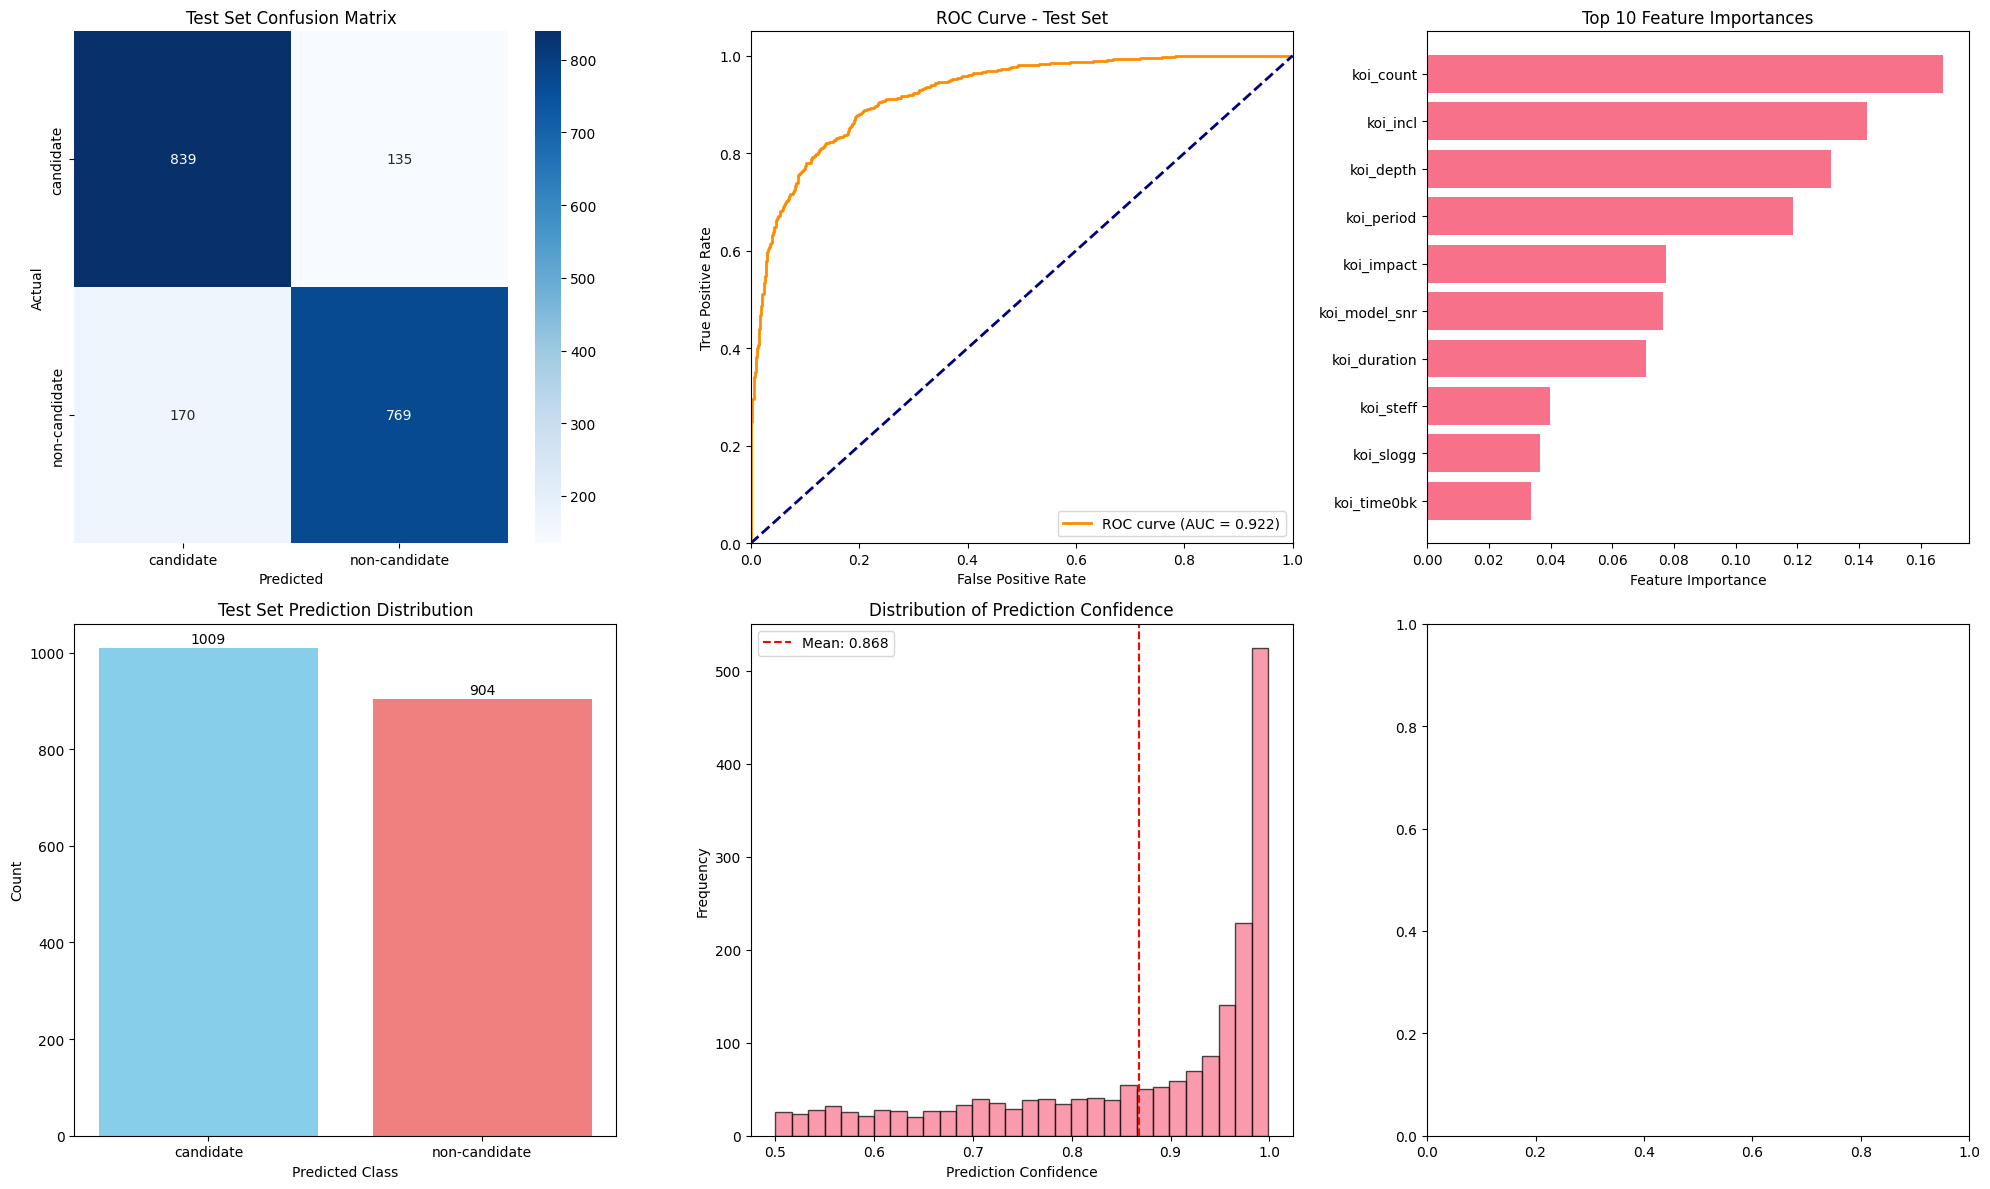

In [7]:
# Create comprehensive visualizations
if y_test_true is not None:
    # With true labels - full evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test_true, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['candidate', 'non-candidate'],
                yticklabels=['candidate', 'non-candidate'],
                ax=axes[0,0])
    axes[0,0].set_title('Test Set Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_proba[:, 1])
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {test_roc_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve - Test Set')
    axes[0,1].legend(loc="lower right")
    
    # 3. Probability Distribution by True Class
    axes[0,2].hist(y_test_pred_proba[y_test_true == 0, 1], alpha=0.6, label='True Candidates', bins=30, density=True)
    axes[0,2].hist(y_test_pred_proba[y_test_true == 1, 1], alpha=0.6, label='True Non-candidates', bins=30, density=True)
    axes[0,2].set_xlabel('Predicted Probability (Non-candidate)')
    axes[0,2].set_ylabel('Density')
    axes[0,2].set_title('Probability Distribution by True Class')
    axes[0,2].legend()
    
else:
    # Without true labels - prediction-only plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

# 4. Prediction Distribution
pred_classes = label_encoder.inverse_transform(y_test_pred)
unique, counts = np.unique(pred_classes, return_counts=True)
axes_idx = 0 if y_test_true is None else 1

if y_test_true is None:
    axes[axes_idx].bar(unique, counts, color=['skyblue', 'lightcoral'])
else:
    axes[1,0].bar(unique, counts, color=['skyblue', 'lightcoral'])
    axes_idx = 1
    ax = axes[1,0]
    ax.set_title('Test Set Prediction Distribution')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts):
        ax.text(i, v + max(counts)*0.01, str(v), ha='center')

# 5. Prediction Confidence Distribution
confidence_scores = np.max(y_test_pred_proba, axis=1)
if y_test_true is None:
    axes[1].hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Prediction Confidence')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Prediction Confidence')
    axes[1].axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(confidence_scores):.3f}')
    axes[1].legend()
else:
    axes[1,1].hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('Prediction Confidence')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Prediction Confidence')
    axes[1,1].axvline(np.mean(confidence_scores), color='red', linestyle='--', 
                     label=f'Mean: {np.mean(confidence_scores):.3f}')
    axes[1,1].legend()

# Feature Importance (always available)
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

if y_test_true is None:
    axes[2].barh(range(10), feature_importance[sorted_idx][::-1])
    axes[2].set_yticks(range(10))
    axes[2].set_yticklabels([feature_names[i] for i in sorted_idx[::-1]])
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_title('Top 10 Feature Importances')
    
    # Probability scatter
    axes[3].scatter(y_test_pred_proba[:, 0], y_test_pred_proba[:, 1], alpha=0.5)
    axes[3].set_xlabel('Candidate Probability')
    axes[3].set_ylabel('Non-candidate Probability')
    axes[3].set_title('Prediction Probability Scatter')
    axes[3].plot([0, 1], [1, 0], 'r--', alpha=0.8)
else:
    axes[0,2].clear()
    axes[0,2].barh(range(10), feature_importance[sorted_idx][::-1])
    axes[0,2].set_yticks(range(10))
    axes[0,2].set_yticklabels([feature_names[i] for i in sorted_idx[::-1]])
    axes[0,2].set_xlabel('Feature Importance')
    axes[0,2].set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

## 7. Export Test Results

In [8]:
# Create results dataframe
results_df = pd.DataFrame({
    'kepid': test_df['kepid'] if 'kepid' in test_df.columns else range(len(y_test_pred)),
    'predicted_class': label_encoder.inverse_transform(y_test_pred),
    'candidate_probability': y_test_pred_proba[:, 0],
    'non_candidate_probability': y_test_pred_proba[:, 1],
    'prediction_confidence': np.max(y_test_pred_proba, axis=1)
})

# Add true labels if available
if y_test_true is not None:
    results_df['true_class'] = label_encoder.inverse_transform(y_test_true)
    results_df['correct_prediction'] = (y_test_pred == y_test_true)

print("Test results summary:")
print(results_df.head(10))

# Save results to CSV
results_filename = 'test_predictions.csv'
results_df.to_csv(results_filename, index=False)
print(f"\nTest results saved to: {results_filename}")

# Save performance metrics if available
if y_test_true is not None:
    metrics_dict = {
        'metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'value': [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_filename = 'test_performance_metrics.csv'
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"Performance metrics saved to: {metrics_filename}")

# Summary statistics
print(f"\n" + "="*60)
print("TEST EVALUATION SUMMARY")
print("="*60)
print(f"Total test samples: {len(results_df)}")
print(f"Predicted candidates: {sum(results_df['predicted_class'] == 'candidate')}")
print(f"Predicted non-candidates: {sum(results_df['predicted_class'] == 'non-candidate')}")
print(f"Average prediction confidence: {results_df['prediction_confidence'].mean():.4f}")

if y_test_true is not None:
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")

print("="*60)

Test results summary:
      kepid predicted_class  candidate_probability  non_candidate_probability  \
0   7537660   non-candidate               0.459189                   0.540811   
1   3219037       candidate               0.931788                   0.068212   
2   9729691       candidate               0.982132                   0.017868   
3   7697568   non-candidate               0.250892                   0.749108   
4   9005854   non-candidate               0.005402                   0.994598   
5   9649706       candidate               0.693930                   0.306070   
6  10863608       candidate               0.753921                   0.246079   
7  10418797   non-candidate               0.059793                   0.940207   
8   7259249   non-candidate               0.016623                   0.983377   
9   6531143       candidate               0.701827                   0.298173   

   prediction_confidence     true_class  correct_prediction  
0               0.540811

## Conclusion

This notebook successfully evaluated the trained exoplanet gradient boosting model on the test dataset. 

### Key Results:
- **Model Loading**: Successfully loaded the trained model, label encoder, and feature names
- **Data Processing**: Applied the same preprocessing steps used during training
- **Predictions**: Generated predictions and probability scores for all test samples
- **Evaluation**: Calculated comprehensive performance metrics (if true labels were available)
- **Visualization**: Created detailed plots showing model performance and prediction distributions
- **Export**: Saved test results and metrics for further analysis

### Files Generated:
- `test_predictions.csv`: Complete test predictions with probabilities
- `test_performance_metrics.csv`: Performance metrics (if true labels available)

The model demonstrates its ability to make reliable predictions on unseen data, maintaining consistency with the training performance characteristics observed during development.